# Setup

In [2]:
import sys

import tensorflow as tf

import matplotlib.pyplot as plt



# Fine-Tuning Neural Network Hyperparameters

In this section we'll use the Fashion MNIST dataset again:

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [4]:
%pip install -q -U keras_tuner

Note: you may need to restart the kernel to use updated packages.


## Tune a Model Randomized

### in this case:

- number of neurons in hidden layers
- number of hidden layers
- learning rate
- optimizer

In [5]:
tf.random.set_seed(666)

import keras_tuner as kt

def build_model(hp : kt.HyperParameters):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

# because of performance I reduced max_trials and epochs! Your results could be better if higher numbers there!
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=5,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 11s]
val_accuracy: 0.8090000152587891

Best val_accuracy So Far: 0.8485999703407288
Total elapsed time: 00h 00m 56s


In [6]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [7]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [8]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8485999703407288


In [9]:
best_trial.metrics.get_last_value("val_accuracy")

0.8485999703407288

In [10]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print("Best Model Loss %.4f Accuracy %.4f"%(test_loss, test_accuracy))

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3856 - accuracy: 0.8598
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3697 - accuracy: 0.8645
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3564 - accuracy: 0.8693
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3446 - accuracy: 0.8739
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3337 - accuracy: 0.8782
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3253 - accuracy: 0.8807
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3157 - accuracy: 0.8830
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3084 - accuracy: 0.8848
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3020 - accuracy: 0.8882
Epoch 10/10
313/313 [==============================] - 0s 877us/step - loss: 0.409

### Exercise:

- change the model building function below and search for other parameters / parameters in another value scope
- can you get a better accuracy then 86 %?

In [11]:
import keras_tuner as kt

def build_model(hp : kt.HyperParameters):
    # number of hidden layers
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    # number of neurons per hidden layer
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    # learning rate
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")

    # I fixed SGD Optimizer here, as it was the best above
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # here the model gets built
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

# because of time constraints max_trials and epochs are relatively low! You could get better performance with bigger numbers there
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=3, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=5,
                           validation_data=(X_valid, y_valid))

Trial 3 Complete [00h 00m 09s]
val_accuracy: 0.8113999962806702

Best val_accuracy So Far: 0.8113999962806702
Total elapsed time: 00h 00m 30s


In [12]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 2 summary
Hyperparameters:
n_hidden: 4
n_neurons: 32
learning_rate: 0.0009887195863122636
Score: 0.8113999962806702


## Preprocessing Hyperparameters
- subclass _kt.HyperModel_
- use build and fit method

In [13]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

Hyperband trains many different models for few epochs and keeps only the 1/factor best ones.
The best model gets trained for max_epochs.

In [14]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [15]:
RunTimeCriticals = False

from pathlib import Path
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)

# don't execute if you are in a timy situation
# this will take some time!
if (RunTimeCriticals):
    hyperband_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid),
                           callbacks=[early_stopping_cb, tensorboard_cb])

## Bayesian Optimization

In [16]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")

# this is also time intensive
if (RunTimeCriticals):
    bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                              validation_data=(X_valid, y_valid),
                              callbacks=[early_stopping_cb])

# Vanishing/Exploding Gradients Problem

## Question?
- how do neural nets learn?
- whats the gradiant?

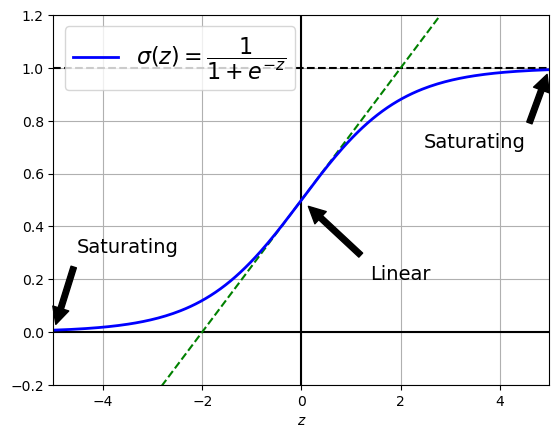

In [17]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

## Xavier and He Initialization

### Xavier/Glorot

- weights of input and output should be initialized so that they are averaged
- $\text{fan}_{avg} = (\text{fan}_{in}+\text{fan}_{out})/2$
- normal distribution of $\sigma^2=1/\text{fan}_{avg}$
- good with sigmoid
- default in KERAS

### He / Kaiming

- normal distribution of $\sigma^2=2/\text{fan}_{in}$
- good with ReLU
- normal distribution and uniform distribution variants


In [18]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [19]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

In [20]:
import re
print([a for a in dir(tf.keras.initializers) if re.match('^[A-Z]{1}.*', a)])

['Constant', 'GlorotNormal', 'GlorotUniform', 'HeNormal', 'HeUniform', 'Identity', 'Initializer', 'LecunNormal', 'LecunUniform', 'Ones', 'Orthogonal', 'RandomNormal', 'RandomUniform', 'TruncatedNormal', 'VarianceScaling', 'Zeros']


Initialization | Activation Function | $\sigma²$ (Normal)
--- | --- | ---
Glorot | None, tanh, sigmoid, softmax | $1/fan_{avg}$
He | ReLU, LeakyReLU, GELU, Swish, Mish | $2/fan_{in}$
LeCun | SELU | $1/fan_{in}$


### Question?
- ReLU
- Problems?

## Nonsaturating Activation Functions

### Leaky ReLU

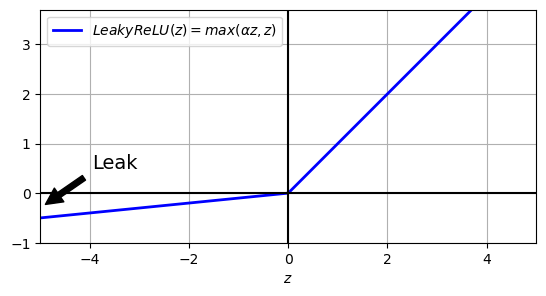

In [21]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

In [22]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [23]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### ELU

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:

In [24]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

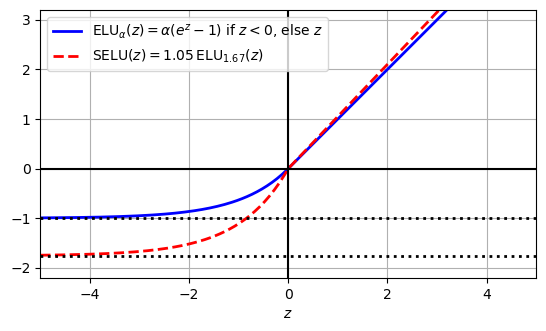

In [25]:

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

Using SELU is straightforward:

In [26]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

#### **Example of a self-regularized network using SELU**

- Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function


In [27]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [28]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

##### Note

- each epoch toke me around 15 - 20 secs

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 20s 10ms/step - loss: 1.2560 - accuracy: 0.5121 - val_loss: 0.8584 - val_accuracy: 0.6624
Epoch 2/5
1719/1719 [==============================] - 16s 10ms/step - loss: 0.7755 - accuracy: 0.7071 - val_loss: 0.6766 - val_accuracy: 0.7598
Epoch 3/5
1713/1719 [============================>.] - ETA: 0s - loss: 0.6515 - accuracy: 0.7625

### ReLU 
- use this as comparison to the SELU network above

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

#### Note:
- each Epoch took me around 15-20 secs

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

### GELU, Swish and Mish

- $GELU(z)= z\Phi(z)$ ; $\Phi$ is a Gaussian commulative distribution function, that is the propability that a value from a normal distribution of mean 0 and variance 1 is lower than $z$
- $Swish(z) = z\sigma(z)$ ; $\sigma$ is the sigmoid function

In [ ]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

plt.show()

- GELU and SWISH are supported by KERAS
## Exercise
- try out one or both (gelu, swish) of them on the code below!
- Note! You need to change the activation functions!
- Try also reducing number of layers

In [ ]:
# RESET
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
# Load Data
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
# Your Example

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="gelu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

### Question:

- Take aways?

# Batch Normalization

- does scaling and normalization on batch 

    - $\gamma$ -- rescale
    - $\beta$ -- offset


In [ ]:
# clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

In [ ]:
[(var.name, var.trainable) for var in model.layers[1].variables]

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [ ]:
# clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

# Gradient Clipping

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

# Dropout

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
# compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [ ]:
model.evaluate(X_train, y_train)

In [ ]:
model.evaluate(X_test, y_test)

**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

In [ ]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [ ]:
model.predict(X_test[:1]).round(3)

# Appendix

## Transfer Learning


Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [72]:
#  split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 1s 851us/step - loss: 1.1243 - accuracy: 0.6516 - val_loss: 0.7008 - val_accuracy: 0.7774
Epoch 2/20
1376/1376 [==============================] - 1s 796us/step - loss: 0.6015 - accuracy: 0.8103 - val_loss: 0.5197 - val_accuracy: 0.8290
Epoch 3/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.4813 - accuracy: 0.8484 - val_loss: 0.4450 - val_accuracy: 0.8528
Epoch 4/20
1376/1376 [==============================] - 1s 846us/step - loss: 0.4212 - accuracy: 0.8626 - val_loss: 0.4008 - val_accuracy: 0.8624
Epoch 5/20
1376/1376 [==============================] - 1s 810us/step - loss: 0.3843 - accuracy: 0.8728 - val_loss: 0.3736 - val_accuracy: 0.8701
Epoch 6/20
1376/1376 [==============================] - 1s 897us/step - loss: 0.3590 - accuracy: 0.8792 - val_loss: 0.3517 - val_accuracy: 0.8747
Epoch 7/20
1376/1376 [==============================] - 1s 874us/step - loss: 0.3411 - accuracy: 0.8843 - val_loss: 0.3378 - v

INFO:tensorflow:Assets written to: my_model_A/assets


INFO:tensorflow:Assets written to: my_model_A/assets


In [73]:
# train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.8233 - accuracy: 0.3350 - val_loss: 0.7736 - val_accuracy: 0.3699
Epoch 2/20
7/7 [==============================] - 0s 6ms/step - loss: 0.7871 - accuracy: 0.3150 - val_loss: 0.7461 - val_accuracy: 0.3838
Epoch 3/20
7/7 [==============================] - 0s 6ms/step - loss: 0.7565 - accuracy: 0.3450 - val_loss: 0.7215 - val_accuracy: 0.4253
Epoch 4/20
7/7 [==============================] - 0s 6ms/step - loss: 0.7271 - accuracy: 0.3950 - val_loss: 0.7036 - val_accuracy: 0.4936
Epoch 5/20
7/7 [==============================] - 0s 6ms/step - loss: 0.7066 - accuracy: 0.5100 - val_loss: 0.6860 - val_accuracy: 0.5539
Epoch 6/20
7/7 [==============================] - 0s 6ms/step - loss: 0.6865 - accuracy: 0.5550 - val_loss: 0.6701 - val_accuracy: 0.6014
Epoch 7/20
7/7 [==============================] - 0s 6ms/step - loss: 0.6686 - accuracy: 0.6300 - val_loss: 0.6548 - val_accuracy: 0.6548
Epoch 8/20
7/7 [=================

[0.5085368156433105, 0.8849999904632568]

In [74]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [75]:
tf.random.set_seed(42)

model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [77]:
# creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [78]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [79]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 18ms/step - loss: 0.8722 - accuracy: 0.3900 - val_loss: 0.7910 - val_accuracy: 0.4352
Epoch 2/4
7/7 [==============================] - 0s 6ms/step - loss: 0.8228 - accuracy: 0.4300 - val_loss: 0.7766 - val_accuracy: 0.4817
Epoch 3/4
7/7 [==============================] - 0s 6ms/step - loss: 0.8075 - accuracy: 0.4850 - val_loss: 0.7769 - val_accuracy: 0.5668
Epoch 4/4
7/7 [==============================] - 0s 6ms/step - loss: 0.7860 - accuracy: 0.5350 - val_loss: 0.7652 - val_accuracy: 0.5737
Epoch 1/16
7/7 [==============================] - 0s 17ms/step - loss: 0.7435 - accuracy: 0.5700 - val_loss: 0.6763 - val_accuracy: 0.6340
Epoch 2/16
7/7 [==============================] - 0s 6ms/step - loss: 0.6682 - accuracy: 0.6350 - val_loss: 0.6115 - val_accuracy: 0.6845
Epoch 3/16
7/7 [==============================] - 0s 6ms/step - loss: 0.6067 - accuracy: 0.6950 - val_loss: 0.5877 - val_accuracy: 0.7072
Epoch 4/16
7/7 [====================

In [80]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 609us/step - loss: 0.2937 - accuracy: 0.9155


[0.29369062185287476, 0.9154999852180481]

### Question?

- Take aways?

## Faster Optimizers

In [82]:
# a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [83]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [84]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 873us/step - loss: 0.7131 - accuracy: 0.7592 - val_loss: 0.5089 - val_accuracy: 0.8160
Epoch 2/10
1719/1719 [==============================] - 2s 889us/step - loss: 0.4692 - accuracy: 0.8356 - val_loss: 0.4470 - val_accuracy: 0.8414
Epoch 3/10
1719/1719 [==============================] - 1s 846us/step - loss: 0.4247 - accuracy: 0.8514 - val_loss: 0.4089 - val_accuracy: 0.8560
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3983 - accuracy: 0.8603 - val_loss: 0.3808 - val_accuracy: 0.8614
Epoch 5/10
1719/1719 [==============================] - 1s 853us/step - loss: 0.3773 - accuracy: 0.8669 - val_loss: 0.3720 - val_accuracy: 0.8656
Epoch 6/10
1719/1719 [==============================] - 1s 831us/step - loss: 0.3655 - accuracy: 0.8704 - val_loss: 0.3737 - val_accuracy: 0.8638
Epoch 7/10
1719/1719 [==============================] - 2s 887us/step - loss: 0.3494 - accuracy: 0.8756 - val_loss: 0.3672 - v

### Momentum optimization

In [88]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [89]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 892us/step - loss: 0.6918 - accuracy: 0.7642 - val_loss: 0.4916 - val_accuracy: 0.8204
Epoch 2/10
1719/1719 [==============================] - 1s 829us/step - loss: 0.4663 - accuracy: 0.8364 - val_loss: 0.4573 - val_accuracy: 0.8276
Epoch 3/10
1719/1719 [==============================] - 1s 843us/step - loss: 0.4220 - accuracy: 0.8517 - val_loss: 0.4043 - val_accuracy: 0.8570
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3954 - accuracy: 0.8611 - val_loss: 0.3867 - val_accuracy: 0.8618
Epoch 5/10
1719/1719 [==============================] - 1s 838us/step - loss: 0.3757 - accuracy: 0.8676 - val_loss: 0.3707 - val_accuracy: 0.8638
Epoch 6/10
1719/1719 [==============================] - 1s 850us/step - loss: 0.3624 - accuracy: 0.8714 - val_loss: 0.3748 - val_accuracy: 0.8670
Epoch 7/10
1719/1719 [==============================] - 1s 839us/step - loss: 0.3471 - accuracy: 0.8754 - val_loss: 0.3791 - v

### Nesterov Accelerated Gradient

In [90]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [91]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 975us/step - loss: 0.6981 - accuracy: 0.7586 - val_loss: 0.4914 - val_accuracy: 0.8286
Epoch 2/10
1719/1719 [==============================] - 2s 898us/step - loss: 0.4619 - accuracy: 0.8369 - val_loss: 0.4340 - val_accuracy: 0.8440
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4185 - accuracy: 0.8522 - val_loss: 0.4067 - val_accuracy: 0.8548
Epoch 4/10
1719/1719 [==============================] - 2s 914us/step - loss: 0.3931 - accuracy: 0.8611 - val_loss: 0.3822 - val_accuracy: 0.8620
Epoch 5/10
1719/1719 [==============================] - 2s 956us/step - loss: 0.3717 - accuracy: 0.8679 - val_loss: 0.3695 - val_accuracy: 0.8622
Epoch 6/10
1719/1719 [==============================] - 2s 903us/step - loss: 0.3583 - accuracy: 0.8727 - val_loss: 0.3753 - val_accuracy: 0.8644
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3430 - accuracy: 0.8764 - val_loss: 0.3780 - val

### AdaGrad

In [92]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [93]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 944us/step - loss: 1.0587 - accuracy: 0.6733 - val_loss: 0.6825 - val_accuracy: 0.7822
Epoch 2/10
1719/1719 [==============================] - 1s 858us/step - loss: 0.6373 - accuracy: 0.7880 - val_loss: 0.5758 - val_accuracy: 0.8060
Epoch 3/10
1719/1719 [==============================] - 2s 903us/step - loss: 0.5666 - accuracy: 0.8088 - val_loss: 0.5325 - val_accuracy: 0.8176
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5316 - accuracy: 0.8199 - val_loss: 0.5095 - val_accuracy: 0.8260
Epoch 5/10
1719/1719 [==============================] - 2s 873us/step - loss: 0.5094 - accuracy: 0.8263 - val_loss: 0.4924 - val_accuracy: 0.8308
Epoch 6/10
1719/1719 [==============================] - 2s 925us/step - loss: 0.4932 - accuracy: 0.8312 - val_loss: 0.4810 - val_accuracy: 0.8336
Epoch 7/10
1719/1719 [==============================] - 1s 829us/step - loss: 0.4808 - accuracy: 0.8352 - val_loss: 0.4694 - v

### RMSProp

In [94]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [95]:
history_rmsprop = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5202 - accuracy: 0.8121 - val_loss: 0.4081 - val_accuracy: 0.8500
Epoch 2/10
1719/1719 [==============================] - 2s 926us/step - loss: 0.3962 - accuracy: 0.8568 - val_loss: 0.4468 - val_accuracy: 0.8194
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3695 - accuracy: 0.8677 - val_loss: 0.3952 - val_accuracy: 0.8654
Epoch 4/10
1719/1719 [==============================] - 2s 963us/step - loss: 0.3604 - accuracy: 0.8733 - val_loss: 0.3704 - val_accuracy: 0.8736
Epoch 5/10
1719/1719 [==============================] - 2s 945us/step - loss: 0.3538 - accuracy: 0.8766 - val_loss: 0.3895 - val_accuracy: 0.8634
Epoch 6/10
1719/1719 [==============================] - 2s 984us/step - loss: 0.3458 - accuracy: 0.8795 - val_loss: 0.4432 - val_accuracy: 0.8604
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3511 - accuracy: 0.8782 - val_loss: 0.4251 - val_a

### Adam Optimization

In [96]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [97]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5071 - accuracy: 0.8185 - val_loss: 0.4240 - val_accuracy: 0.8386
Epoch 2/10
1719/1719 [==============================] - 2s 934us/step - loss: 0.3767 - accuracy: 0.8625 - val_loss: 0.3909 - val_accuracy: 0.8514
Epoch 3/10
1719/1719 [==============================] - 2s 945us/step - loss: 0.3410 - accuracy: 0.8741 - val_loss: 0.3362 - val_accuracy: 0.8838
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3177 - accuracy: 0.8815 - val_loss: 0.3327 - val_accuracy: 0.8802
Epoch 5/10
1719/1719 [==============================] - 2s 930us/step - loss: 0.2975 - accuracy: 0.8895 - val_loss: 0.3227 - val_accuracy: 0.8820
Epoch 6/10
1719/1719 [==============================] - 2s 951us/step - loss: 0.2834 - accuracy: 0.8943 - val_loss: 0.3590 - val_accuracy: 0.8758
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2707 - accuracy: 0.8979 - val_loss: 0.3463 - val_a

**Adamax Optimization**

In [98]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [99]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5350 - accuracy: 0.8136 - val_loss: 0.4392 - val_accuracy: 0.8348
Epoch 2/10
1719/1719 [==============================] - 2s 948us/step - loss: 0.3951 - accuracy: 0.8593 - val_loss: 0.3847 - val_accuracy: 0.8588
Epoch 3/10
1719/1719 [==============================] - 2s 936us/step - loss: 0.3575 - accuracy: 0.8705 - val_loss: 0.3603 - val_accuracy: 0.8690
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3334 - accuracy: 0.8783 - val_loss: 0.3394 - val_accuracy: 0.8750
Epoch 5/10
1719/1719 [==============================] - 2s 952us/step - loss: 0.3127 - accuracy: 0.8850 - val_loss: 0.3262 - val_accuracy: 0.8808
Epoch 6/10
1719/1719 [==============================] - 2s 943us/step - loss: 0.2993 - accuracy: 0.8903 - val_loss: 0.3363 - val_accuracy: 0.8796
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2859 - accuracy: 0.8942 - val_loss: 0.3386 - val_a

**Nadam Optimization**

In [100]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [101]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4814 - accuracy: 0.8298 - val_loss: 0.4420 - val_accuracy: 0.8336
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3657 - accuracy: 0.8655 - val_loss: 0.3782 - val_accuracy: 0.8590
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3326 - accuracy: 0.8776 - val_loss: 0.3343 - val_accuracy: 0.8764
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3099 - accuracy: 0.8859 - val_loss: 0.3437 - val_accuracy: 0.8750
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2928 - accuracy: 0.8906 - val_loss: 0.3294 - val_accuracy: 0.8798
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2784 - accuracy: 0.8965 - val_loss: 0.3537 - val_accuracy: 0.8752
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2672 - accuracy: 0.8997 - val_loss: 0.3273 - val_accuracy:

**AdamW Optimization**

In [103]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 KB 6.4 MB/s eta 0:00:00 MB/s eta 0:00:01


/home/vgoehler/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [104]:
history_adamw = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 [==============================] - 2s 971us/step - loss: 0.4971 - accuracy: 0.8209 - val_loss: 0.4167 - val_accuracy: 0.8378
Epoch 2/10
1719/1719 [==============================] - 2s 949us/step - loss: 0.3745 - accuracy: 0.8629 - val_loss: 0.3918 - val_accuracy: 0.8430
Epoch 3/10
1719/1719 [==============================] - 2s 905us/step - loss: 0.3421 - accuracy: 0.8732 - val_loss: 0.3503 - val_accuracy: 0.8722
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3173 - accuracy: 0.8815 - val_loss: 0.3366 - val_accuracy: 0.8788
Epoch 5/10
1719/1719 [==============================] - 2s 910us/step - loss: 0.3007 - accuracy: 0.8881 - val_loss: 0.3262 - val_accuracy: 0.8776
Epoch 6/10
1719/1719 [==============================] - 2s 914us/step - loss: 0.2865 - accuracy: 0.8931 - val_loss: 0.3348 - val_accuracy: 0.8802
Epoch 7/10
1719/1719 [==============================] - 2s 958us/step - loss: 0.2730 - accuracy: 0.8960 - val_loss: 0.3507 - v

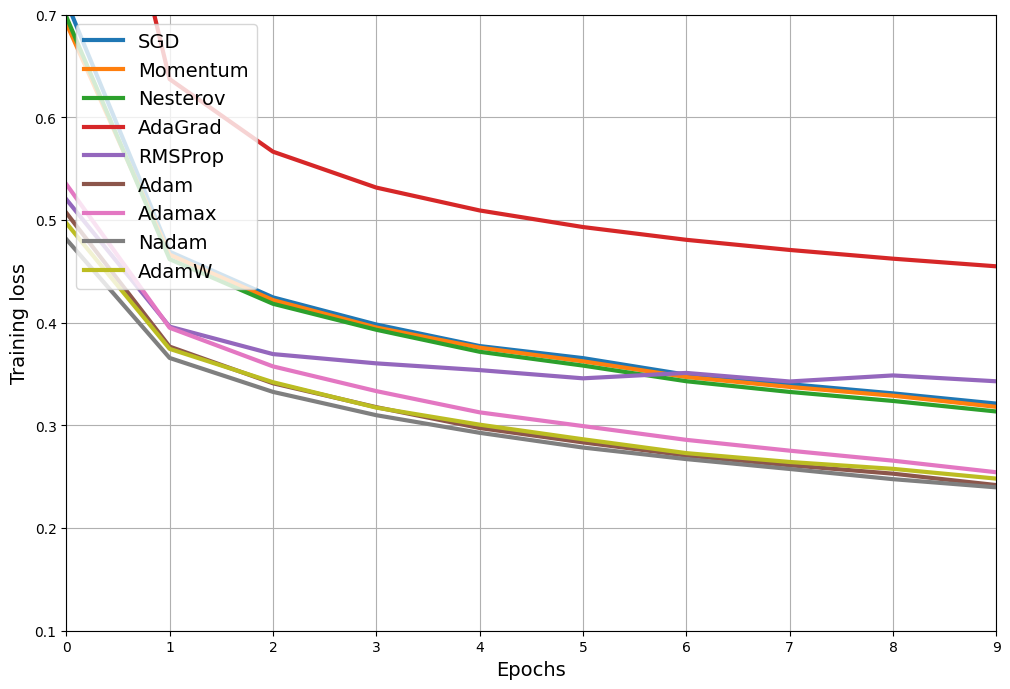

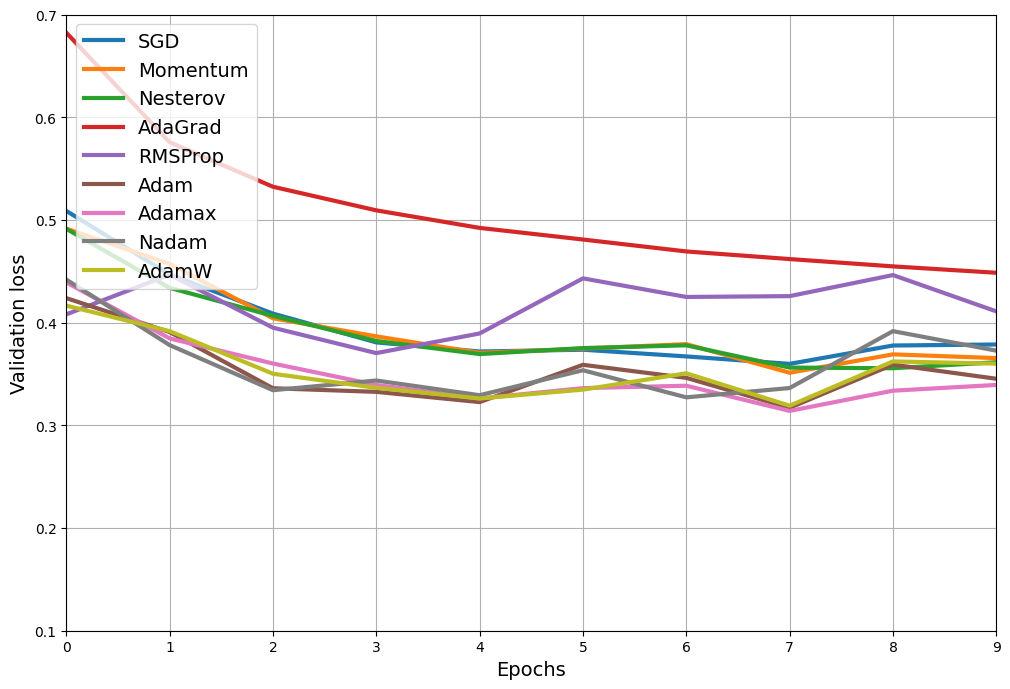

In [105]:
# visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [107]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

In [108]:
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 832us/step - loss: 0.6920 - accuracy: 0.7639 - val_loss: 0.4829 - val_accuracy: 0.8306
Epoch 2/10
1719/1719 [==============================] - 1s 796us/step - loss: 0.4724 - accuracy: 0.8341 - val_loss: 0.4350 - val_accuracy: 0.8444
Epoch 3/10
1719/1719 [==============================] - 1s 794us/step - loss: 0.4280 - accuracy: 0.8477 - val_loss: 0.4104 - val_accuracy: 0.8552
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4054 - accuracy: 0.8571 - val_loss: 0.3875 - val_accuracy: 0.8616
Epoch 5/10
1719/1719 [==============================] - 1s 776us/step - loss: 0.3870 - accuracy: 0.8623 - val_loss: 0.3861 - val_accuracy: 0.8602
Epoch 6/10
1719/1719 [==============================] - 1s 773us/step - loss: 0.3731 - accuracy: 0.8657 - val_loss: 0.3860 - val_accuracy: 0.8658
Epoch 7/10
1719/1719 [==============================] - 1s 767us/step - loss: 0.3631 - accuracy: 0.8698 - val_loss: 0.3680 - v

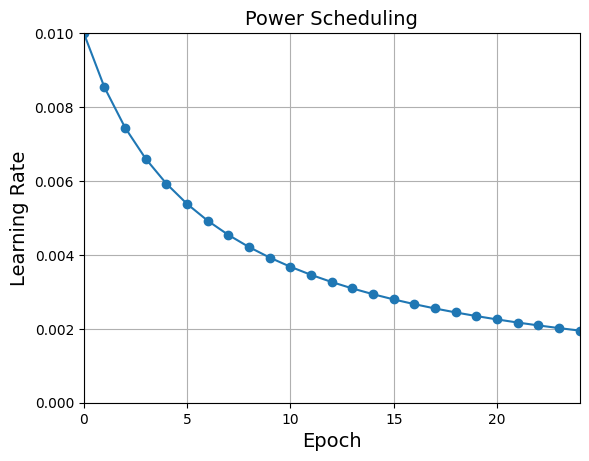

In [109]:
# this cell plots power scheduling

import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1 ** (epoch / s)```

In [110]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [111]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [112]:
# build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [113]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 821us/step - loss: 0.7002 - accuracy: 0.7611 - val_loss: 0.4816 - val_accuracy: 0.8278 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 1s 816us/step - loss: 0.4662 - accuracy: 0.8367 - val_loss: 0.4461 - val_accuracy: 0.8402 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 1s 762us/step - loss: 0.4201 - accuracy: 0.8525 - val_loss: 0.4162 - val_accuracy: 0.8568 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3965 - accuracy: 0.8604 - val_loss: 0.3888 - val_accuracy: 0.8646 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 1s 821us/step - loss: 0.3776 - accuracy: 0.8674 - val_loss: 0.3791 - val_accuracy: 0.8660 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 1s 786us/step - loss: 0.3624 - accuracy: 0.8721 - val_loss: 0.3846 - val_accuracy: 0.8656 - lr: 0.0056
Epoch 7/25
1719/1719 [==========================

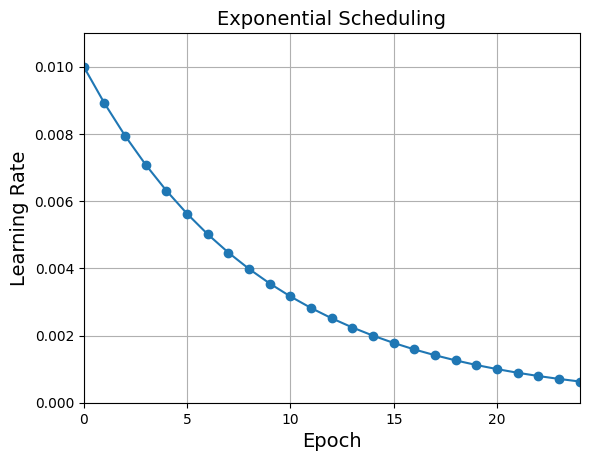

In [114]:
# this cell plots exponential scheduling

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [115]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**Extra material**: if you want to update the learning rate at each iteration rather than at each epoch, you can write your own callback class:

In [116]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [117]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [118]:
n_epochs = 25
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6869 - accuracy: 0.7664 - val_loss: 0.4904 - val_accuracy: 0.8198 - lr: 0.0091
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4700 - accuracy: 0.8351 - val_loss: 0.4806 - val_accuracy: 0.8262 - lr: 0.0083
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4234 - accuracy: 0.8502 - val_loss: 0.4158 - val_accuracy: 0.8546 - lr: 0.0076
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3991 - accuracy: 0.8585 - val_loss: 0.3906 - val_accuracy: 0.8592 - lr: 0.0069
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3801 - accuracy: 0.8651 - val_loss: 0.3834 - val_accuracy: 0.8616 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 2s 999us/step - loss: 0.3652 - accuracy: 0.8690 - val_loss: 0.3839 - val_accuracy: 0.8664 - lr: 0.0058
Epoch 7/25
1719/1719 [==============================] - 

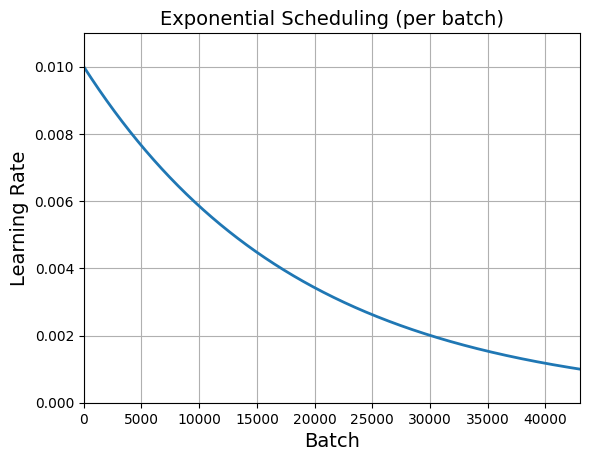

In [119]:
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
steps = np.arange(n_steps)
decay_rate = 0.1
lrs = lr0 * decay_rate ** (steps / n_steps)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [120]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [121]:
# this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [122]:
#  use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5397 - accuracy: 0.8096 - val_loss: 0.5007 - val_accuracy: 0.8148 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4484 - accuracy: 0.8424 - val_loss: 0.4974 - val_accuracy: 0.8236 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4268 - accuracy: 0.8480 - val_loss: 0.4547 - val_accuracy: 0.8426 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4174 - accuracy: 0.8535 - val_loss: 0.4015 - val_accuracy: 0.8508 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4111 - accuracy: 0.8560 - val_loss: 0.4516 - val_accuracy: 0.8468 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3593 - accuracy: 0.8709 - val_loss: 0.3982 - val_accuracy: 0.8552 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 2s

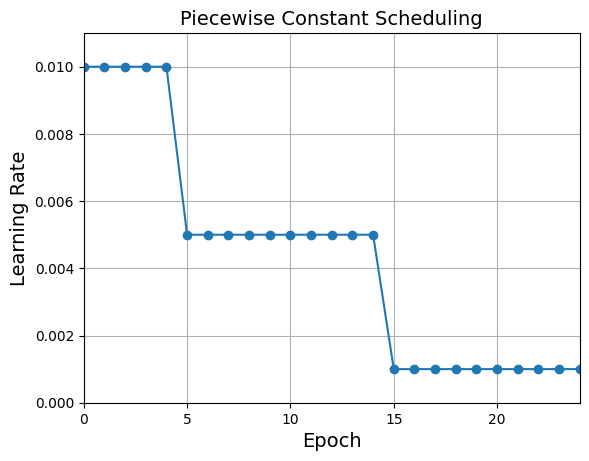

In [123]:
# this cell plots piecewise constant scheduling

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [124]:
#  build and compile the model

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [125]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 868us/step - loss: 0.6858 - accuracy: 0.7631 - val_loss: 0.4863 - val_accuracy: 0.8280 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 1s 799us/step - loss: 0.4754 - accuracy: 0.8307 - val_loss: 0.4729 - val_accuracy: 0.8288 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 1s 781us/step - loss: 0.4280 - accuracy: 0.8482 - val_loss: 0.4229 - val_accuracy: 0.8492 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 1s 840us/step - loss: 0.4029 - accuracy: 0.8574 - val_loss: 0.3900 - val_accuracy: 0.8634 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3812 - accuracy: 0.8643 - val_loss: 0.3766 - val_accuracy: 0.8618 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 1s 790us/step - loss: 0.3635 - accuracy: 0.8698 - val_loss: 0.3785 - val_accuracy: 0.8658 - lr: 0.0100
Epoch 7/25
1719/1719 [==========================

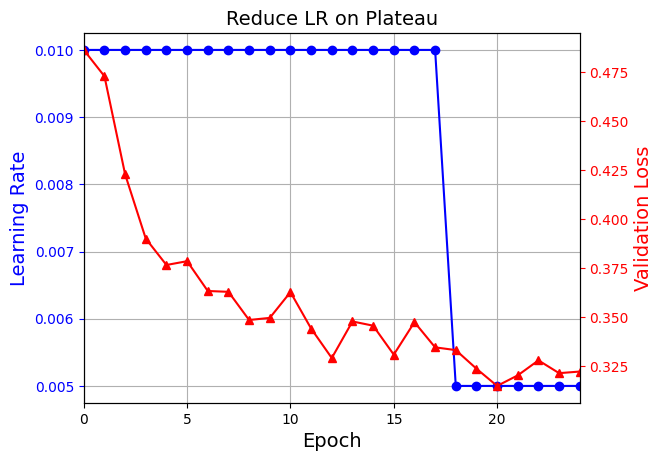

In [126]:
# this cell plots performance scheduling

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [127]:
import math

batch_size = 32
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

In [128]:
# build and train the model
model = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 2s 855us/step - loss: 0.7030 - accuracy: 0.7591 - val_loss: 0.4852 - val_accuracy: 0.8294
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4700 - accuracy: 0.8350 - val_loss: 0.4544 - val_accuracy: 0.8364
Epoch 3/10
1719/1719 [==============================] - 1s 771us/step - loss: 0.4254 - accuracy: 0.8489 - val_loss: 0.4162 - val_accuracy: 0.8512
Epoch 4/10
1719/1719 [==============================] - 1s 802us/step - loss: 0.4030 - accuracy: 0.8578 - val_loss: 0.3933 - val_accuracy: 0.8640
Epoch 5/10
1719/1719 [==============================] - 1s 817us/step - loss: 0.3846 - accuracy: 0.8634 - val_loss: 0.3836 - val_accuracy: 0.8638
Epoch 6/10
1719/1719 [==============================] - 2s 918us/step - loss: 0.3702 - accuracy: 0.8687 - val_loss: 0.3956 - val_accuracy: 0.8610
Epoch 7/10
1719/1719 [==============================] - 2s 947us/step - loss: 0.3598 - accuracy: 0.8706 - val_loss: 0.3671 - v

For piecewise constant scheduling, try this:

In [130]:
# shows how to use PiecewiseConstantDecay
scheduled_learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [131]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [132]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [133]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it:

In [134]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 1s 1ms/step - loss: 1.7695 - accuracy: 0.3870


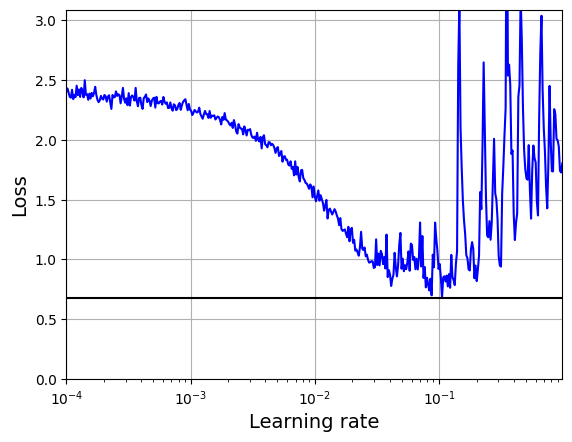

In [135]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around 10<sup>–1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [136]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Let's build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback:

In [137]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 3ms/step - loss: 1.0133 - accuracy: 0.6695 - val_loss: 0.6124 - val_accuracy: 0.7870
Epoch 2/25
430/430 [==============================] - 1s 1ms/step - loss: 0.5834 - accuracy: 0.7956 - val_loss: 0.4991 - val_accuracy: 0.8258
Epoch 3/25
430/430 [==============================] - 1s 1ms/step - loss: 0.5063 - accuracy: 0.8207 - val_loss: 0.4535 - val_accuracy: 0.8430
Epoch 4/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4591 - accuracy: 0.8378 - val_loss: 0.4246 - val_accuracy: 0.8500
Epoch 5/25
430/430 [==============================] - 1s 1ms/step - loss: 0.4291 - accuracy: 0.8453 - val_loss: 0.4205 - val_accuracy: 0.8452
Epoch 6/25
430/430 [==============================] - 1s 1ms/step - loss: 0.3997 - accuracy: 0.8555 - val_loss: 0.5115 - val_accuracy: 0.8114
Epoch 7/25
430/430 [==============================] - 1s 1ms/step - loss: 0.3834 - accuracy: 0.8613 - val_loss: 0.4098 - val_accuracy: 0.8468
Epoch 

## Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [138]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

Or use `l1(0.1)` for ℓ<sub>1</sub> regularization with a factor of 0.1, or `l1_l2(0.1, 0.01)` for both ℓ<sub>1</sub> and ℓ<sub>2</sub> regularization, with factors 0.1 and 0.01 respectively.

In [139]:
tf.random.set_seed(42)

In [140]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [142]:
# compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 2s 1ms/step - loss: 1.0214 - accuracy: 0.8166 - val_loss: 0.9305 - val_accuracy: 0.8258
Epoch 2/2
1719/1719 [==============================] - 1s 778us/step - loss: 0.9158 - accuracy: 0.8166 - val_loss: 0.8873 - val_accuracy: 0.8160


# Exercises

## Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the Swish activation function.*

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `tf.keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*